In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import numba
from numba import jit

from ipywidgets import FloatProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
base_dir = currentdir[:currentdir.index('python')] + 'python/'
sys.path.insert(0,base_dir) 
print("Appended base directory", base_dir)

# Import local libraries
from aux.signal.filter import approxDecayConv, approxLPF, windowAvg1D

# Shorthand correlation and spearmann rank
# corr = lambda x,y : np.corrcoef(x,y)[0,1]
# sprank = lambda x,y : scipy.stats.spearmanr(x,y)[0]
@jit(nopython=True)
def corr(x,y):
    return np.corrcoef(x,y)[0,1]

@jit(nopython=True)
def rankData(x):
    n = len(x)
    idxs = np.argsort(x)
    rez = np.zeros(n)
    for i in range(n):
        rez[idxs[i]] = i
    return rez+1

@jit(nopython=True)
def sprank(x,y):
    n = len(x)
    return 1 - 6 * np.sum((rankData(x) - rankData(y))**2, axis=0) / n / (n*n-1)
    # return np.corrcoef(rankData(x), rankData(y))[0,1]

Appended base directory /media/aleksejs/DataHDD/work/codes/snippets-data-analysis/python/


In [13]:
def regfit(x, y, name):
    coeff = np.polyfit(x, y, 1)
    curve = x*coeff[0] + coeff[1]
    print(name + " fit: %.2f*x + %.2f" % (coeff[0], coeff[1]))
    return curve
   
def loglogfit(x, y, name):
    coeff = np.polyfit(np.log(x), np.log(y), 1)
    curve = x**(coeff[0]) * np.exp(coeff[1])
    print(name + " fit: %.2f*x^%.2f" % (np.exp(coeff[1]), coeff[0]))
    return curve


@jit(nopython=True)
def incremental(x):
    rez = np.copy(x)
    for j in range(1, len(x)):
        rez[j] += rez[j-1]
    return rez

@jit(nopython=True)
def approxDecayConv(data, TAU, DT):
    if TAU == 0:
        return data
    else:
        nPoint = len(data)
        alpha = DT / TAU
        beta = 1 - alpha
        rez = np.zeros(nPoint+1)
        for i in range(nPoint):
            rez[i+1] = rez[i] * beta + data[i]

        return rez[1:] * alpha

# Analysis of inter-dependance

Most general formulation: Let there be $N$ time-dependent observables, that are observed simultaneously at discrete time points. The future values of each observable depends on its own history, the history of all other observables, and also the history of other, non-observed objects. It is of interest to discover completely the equations of motion of the system, which may be exact or probabilistic. Clearly, any finite amount of data can be explained by an infinite number of equally valid equations of motion, so the exact answer to the problem depends on having a strong underlying model and is to some extend arbitrary and philosophical (e.g. to use or not to use Occam's razor). But data always comes before the model. First, exploratory model-free analysis is necessary to get intuition of which models are possible. In particular, it is useful to determine, which observables are independent, which are weakly or strongly dependent on each other. Formally this is also impossible, since even random finite data could be explained by a very complicated dependence function. Also, in order to make any progress on this problem, the laws governing the interaction of the system with any non-observed systems must be completely known a priori. For example, all observables can in general be explained solely by external input, providing zero information about the interactions within the system. Typically it is assumed that there is no external input, external input is random with a known distribution, or, if we are lucky, external input can be manipulated by the observer. In this exercise, we will start from the other end - assuming a very simple setup first, progressively relaxing assumptions.

At first, let us assume two observables, $X$ and $Y$, produce independent and identically distributed (i.i.d) samples from the joint probability distribution $\rho(x,y)$. For such observables, the question of interest is whether they are independent ($\rho(x,y) = \rho(x)\rho(y)$) or not.


### Correlation and Spearmann rank
Questions of interest are:
* What is a sensible threshold to consider cross-correlation or cross-spearmann rank significant
* How do type-1 and type-2 errors depend on noise and window size
* What is the effect of low-pass-filtering both datasets before computing correlation?

**TODO**: Generate linearly-dependent data with different levels of noise. Test correlation with different levels of noise, different window sizes. Also test pre-low-pass-filtering the data

# Part 1. Type 1 error

Type 1 error is identifying a relationship that is not there. In terms of hypothesis testing, it is the incorrect rejection of the null hypothesis. Technically, the null hypothesis stating that data is uncorrelated would be rejected correctly. The problem is that we approximate the null hypothesis of data being unrelated with the null hypothesis of data being uncorrelated, and by correctly rejecting the latter we sometimes incorrectly reject the former.

## Part 1.1 Effect of non-IID distributions

### 1.1.1 IID random data

Check the correlation and spearmann rank between two random datasets, depending on dataset size

**Conclusion:**
Correlation of completely random inputs drops roughly as $1 / (2\sqrt{N})$

Correlation fit: 0.46*x^-0.48
Spearmann fit: 0.54*x^-0.50
CPU times: user 51.4 s, sys: 124 ms, total: 51.5 s
Wall time: 42.5 s


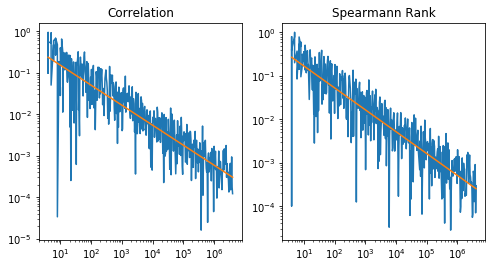

In [16]:
%%time

@jit(nopython=True, parallel=True)
def corrRandData(nData):
    corrData = np.zeros(len(nData))
    sprData = np.zeros(len(nData))
    for i in range(len(nData)):
        x = np.random.normal(0, 1, nData[i])
        y = np.random.normal(0, 1, nData[i])
        corrData[i] = np.abs(corr(x,y))
        sprData[i] = np.abs(sprank(x,y))
        if sprData[i] == 0:
            sprData[i] = 1.0e-4
    return corrData, sprData

nData = np.array([int(2**(2 + i / 20)) for i in range(400)])
corrData, sprData = corrRandData(nData)
    
# Fit line to log-log plot of the resulting data
corrFit = loglogfit(nData, corrData, "Correlation")
sprFit = loglogfit(nData, sprData, "Spearmann")

fig, ax = plt.subplots(ncols = 2, figsize=(8, 4))
ax[0].loglog(nData, corrData)
ax[0].loglog(nData, corrFit)
ax[0].set_title("Correlation")
ax[1].loglog(nData, sprData)
ax[1].loglog(nData, sprFit)
ax[1].set_title("Spearmann Rank");

### 1.1.2 Wiener process

Check the correlation and spearmann rank between two Wiener processes, depending on dataset size

**Conclusion:**
Wiener processes have non-converging mean and variance. Correlation is not applicable to them, because they strongly violate the i.i.d assumption. It is observed that the absolute value of correlation between two completely random processes fluctuates about 0.5, and can be easily mistaken for genuine dependence

Linear Fit fit: 0.07*x + -292.50
Correlation fit: 0.32*x^-0.00
Spearmann fit: 0.27*x^0.01
CPU times: user 36.7 s, sys: 498 ms, total: 37.2 s
Wall time: 27.6 s


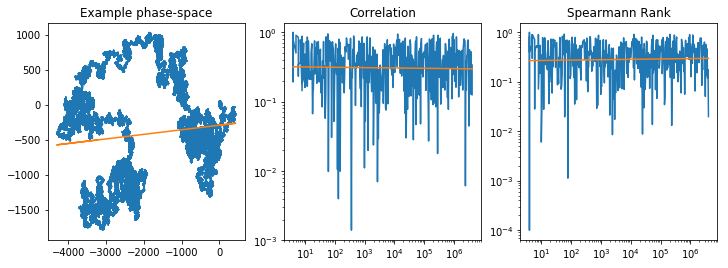

In [15]:
%%time

@jit(nopython=True, parallel=True)
def corrMarkovData(nData):
    corrData = np.zeros(len(nData))
    sprData = np.zeros(len(nData))
    for i in range(len(nData)):
        x = np.random.normal(0, 1, nData[i])
        y = np.random.normal(0, 1, nData[i])
        
        # Convert random data into Markov chains
        x = incremental(x)
        y = incremental(y)
        
        corrData[i] = np.abs(corr(x,y))
        sprData[i] = np.abs(sprank(x,y))
        if sprData[i] == 0:
            sprData[i] = 1.0e-4
    return corrData, sprData, x, y
        
# Compute correlation for markov chains
nData = np.array([int(2**(2 + i / 20)) for i in range(400)])
corrData, sprData, x, y = corrMarkovData(nData)

# Fit line to log-log plot of the resulting data
linFit = regfit(x, y, "Linear Fit")
corrFit = loglogfit(nData, corrData, "Correlation")
sprFit = loglogfit(nData, sprData, "Spearmann")

fig, ax = plt.subplots(ncols = 3, figsize=(12, 4))
ax[0].plot(x, y)
ax[0].plot(x, linFit)
ax[0].set_title("Example phase-space")
ax[1].loglog(nData, corrData)
ax[1].loglog(nData, corrFit)
ax[1].set_title("Correlation")
ax[2].loglog(nData, sprData)
ax[2].loglog(nData, sprFit)
ax[2].set_title("Spearmann Rank")

### 1.1.3 Low-pass filtered random data

Check the correlation and spearmann rank between two processes with exponentially decaying response (lag), depending on dataset size

**Conclusion:**
Laggy process does converge, but requires orders of magnitude more data, depending on the lag

FloatProgress(value=0.0, max=200.0)

CPU times: user 1min 35s, sys: 31.1 ms, total: 1min 35s
Wall time: 1min 35s


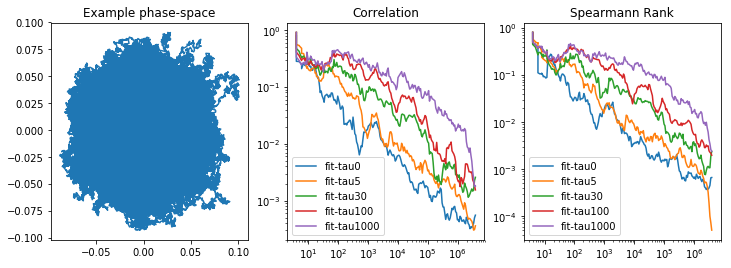

In [12]:
%%time
DT = 1
nStep = 200
nData = np.array([int(2**(2 + i/10)) for i in range(nStep)])
tau = [0, 5, 30, 100, 1000]
nTau = len(tau)

#######################################
# Compute correlations for decay data
#######################################

corrData = np.zeros((nTau, nStep))
sprData = np.zeros((nTau, nStep))

progBar = FloatProgress(min=0, max=nStep) # instantiate the bar
display(progBar) # display the bar

for iData in range(len(nData)):
#     print("doing data size", nData[iData])
    x = np.random.normal(0, 1, nData[iData])
    y = np.random.normal(0, 1, nData[iData])

    for iTau in range(nTau):
        # Convolve data with laggy kernel
        xLPF = approxDecayConv(x, tau[iTau], DT)
        yLPF = approxDecayConv(y, tau[iTau], DT)

        corrData[iTau][iData] = np.abs(corr(xLPF, yLPF))
        sprData[iTau][iData] = np.abs(sprank(xLPF, yLPF))
        if sprData[iTau][iData] == 0:
            sprData[iTau][iData] = 1.0e-5
    
    # Increase progressbar counter
    progBar.value += 1
    
#######################################
# Fit and plot
#######################################
    
# Fit line to log-log plot of the resulting data
corrFit = np.zeros((nTau, nStep))
sprFit = np.zeros((nTau, nStep))
for iTau in range(nTau):
    corrFit[iTau] = np.exp(windowAvg1D(np.log(corrData[iTau]), 10)) #np.exp(smoothWindow(np.log(corrData[iTau]), 40))
    sprFit[iTau] = np.exp(windowAvg1D(np.log(sprData[iTau]), 10)) #np.exp(smoothWindow(np.log(sprData[iTau]), 40))

fig, ax = plt.subplots(ncols = 3, figsize=(12, 4))
ax[0].set_title("Example phase-space")
ax[1].set_title("Correlation")
ax[2].set_title("Spearmann Rank")
ax[0].plot(xLPF, yLPF)
for iTau in range(nTau):
    #ax[1].loglog(nData, corrData[iTau], label = "data-tau"+str(tau[iTau]))
    ax[1].loglog(nData, corrFit[iTau], label = "fit-tau"+str(tau[iTau]))
    #ax[2].loglog(nData, sprData[iTau], label = "data-tau"+str(tau[iTau]))
    ax[2].loglog(nData, sprFit[iTau], label = "fit-tau"+str(tau[iTau]))
ax[1].legend()
ax[2].legend();

## Part 1.2. Effect of cross-correlation

Real random variables can lag with respect to one another, with the precise value of the lag being unknown. One would typically search for the highest correlation within a set of possible lags. Here we investigate by how much would this procedure increase the expected correlation of random data

**[TODO]**
* Construct cross-correlation for random-lpf data with a timescale of $\pm 2 \tau$
* Bin the data using varying bin sizes, see how that affects cross-correlation

## Part 1.3. Typical responses for real data

**[TODO]**
* Generate a bunch of real oscillators with different frequencies
* add velocity and sampling noise to each. 
* Perform correlation between all positions and velocities, check that it can pick up x-v pairs
* Progressively apply decay and use cross-correlation, see if it still works
* Think of a process with faster and slower timescales, such that even with LPF there would still be something left

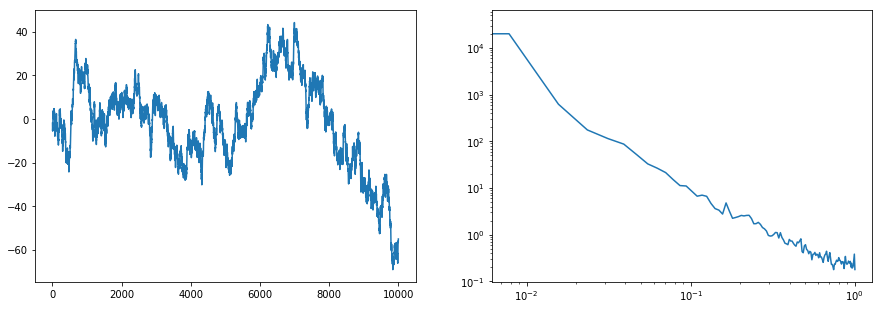

# Part 2. Type 2 Error

Type 2 error is failing to identify data as related when they actually are. That is, failure to reject the true null hypothesis.

## Part 2.1 Dynamics

In physics, the value of one DoF does not typically affect the value of another directly. Instead, it would likely affect the rate of chance of that variable

$\dot{y} = F(x)$

or affect the force acting on it

$\ddot{y} = G(x)$

Let's start with a simple homeostatic equation

$\dot{y} = -\frac{y}{\tau} + x$

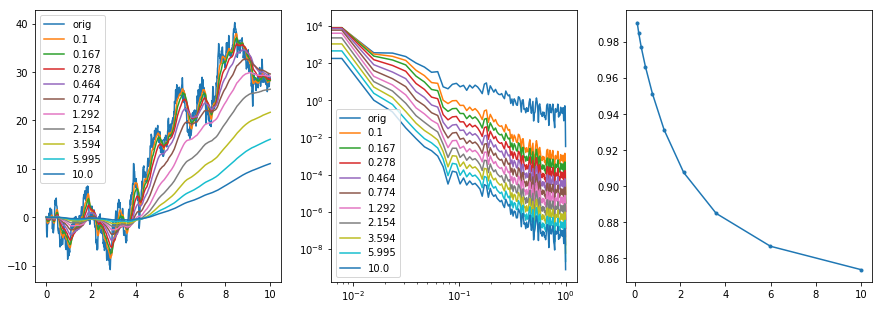

In [55]:
T = 10
dt = 0.01
NT = int(T / dt)
NTAU = 10
tauLst = 0.1 * 10**np.linspace(0, 2, NTAU)


# Generate input data
t = np.linspace(0, T, NT)
rand1 = np.random.normal(0, 1, NT)
x = incremental(rand1)

# Compute PSD
pxx1, f1 = plt.mlab.psd(x)

# Store correlation coefficients
corrData = np.zeros(NTAU)
y = np.zeros((NTAU, NT))

# Generate response data
for iTau, tau in enumerate(tauLst):
    for i in range(1, NT):
        y[iTau, i] = y[iTau, i-1]*(1 - dt/tau) + x[i]*dt/tau

    corrData[iTau] = np.abs(corr(x, y[iTau]))
    
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].plot(t, x, label="orig")
ax[1].loglog(f1, pxx1, label="orig")
for iTau in range(NTAU):
    ax[0].plot(t, y[iTau], label=str(round(tauLst[iTau],3)))
    
    pxx, f = plt.mlab.psd(y[iTau])
    ax[1].loglog(f, pxx, label=str(round(tauLst[iTau],3)))
ax[0].legend()
ax[1].legend()
ax[2].plot(tauLst, corrData, '.-')
plt.show()
